In [ ]:
!pip install gdown
!pip install orange3

     |████████████████████████████████| 25.3 MB 89 kB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 18.4 MB/s 
     |████████████████████████████████| 959 kB 33.6 MB/s 
     |████████████████████████████████| 485 kB 44.5 MB/s 
     |████████████████████████████████| 229 kB 58.2 MB/s 
     |████████████████████████████████| 47 kB 4.5 MB/s 
     |████████████████████████████████| 251 kB 53.9 MB/s 
     |████████████████████████████████| 149 kB 58.6 MB/s 
     |████████████████████████████████| 8.3 MB 35.7 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
     |████████████████████████████████| 59.9 MB 37 kB/s 
     |████████████████████████████████| 317 kB 55.9 MB/s 
     |████████████████████████████████| 67.5 MB 33 kB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |███████████████████████

In [ ]:
!gdown https://drive.google.com/uc?id=126dO4VNhLpYKT0TKp18RTAGjrHAl_ZpU -O mnist.npz
!gdown https://drive.google.com/uc?id=16wlkaf6GCGX0aJTOtzDo0ypnhqYZ7GVM -O kmnist.npz
!gdown https://drive.google.com/uc?id=1XMH39lcD2bnwy4AW3S-4-0Ge7JIYw6CF -O eurosat.npz
!gdown https://drive.google.com/uc?id=1BsfU84WJMRRKG3wzRZG6KuCperlLrxHc -O cifar10.npz

Downloading...
From: https://drive.google.com/uc?id=126dO4VNhLpYKT0TKp18RTAGjrHAl_ZpU
To: /content/mnist.npz
55.4MB [00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=16wlkaf6GCGX0aJTOtzDo0ypnhqYZ7GVM
To: /content/kmnist.npz
55.4MB [00:00, 67.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XMH39lcD2bnwy4AW3S-4-0Ge7JIYw6CF
To: /content/eurosat.npz
333MB [00:02, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BsfU84WJMRRKG3wzRZG6KuCperlLrxHc
To: /content/cifar10.npz
186MB [00:01, 118MB/s]


In [ ]:
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications import InceptionV3, ResNet50V2, EfficientNetB1, DenseNet169
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda, Input
from tensorflow.image import resize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from Orange.evaluation import compute_CD, graph_ranks
from scipy.stats import friedmanchisquare, rankdata
import numpy as np
import pandas as pd
import tensorflow as tf
import re, os, time, requests
import matplotlib.pyplot as plt

In [ ]:
DATASETS = {
    'mnist': {
        'shape': (28, 28, 1),
        'classes': 10,
        'proposal': '(((conv*3)bnorm-pool-)*2)fc*2*128*lr-0.001',
    },
    'kmnist': {
        'shape': (28, 28, 1),
        'classes': 10,
        'proposal': '(((conv*2)bnorm-pool-)*3)fc*2*128*lr-0.001',
    },
    'eurosat': {
        'shape': (64, 64, 3),
        'classes': 10,
        'proposal': '(((conv*3)bnorm-pool-)*3)fc*0*64*lr-0.001',
    },
    'cifar10': {
        'shape': (32, 32, 3),
        'classes': 10,
        'proposal': '(((conv*3)bnorm-pool-dropout)*3)fc*1*256*lr-0.001',
    },
}
CNNS = ['Proposal', 'InceptionV3', 'ResNet50V2', 'EfficientNetB1', 'DenseNet169']
NUM_SAMPLES = 10
METRICS_URL = 'https://gemetrics.herokuapp.com/api/analysis/'

In [ ]:
def load_dataset(dataset_name):

  shape = DATASETS[dataset_name]['shape']
  dataset = np.load('%s.npz' % dataset_name, allow_pickle=True)

  if dataset_name == 'eurosat':

    train = dataset['train'].tolist()

    train_images, train_labels = train['image'], train['label']

    train_images = train_images.reshape((train_images.shape[0], *shape))
    train_images = train_images.astype("float") / 255.0

    train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
    validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

  else:

    train = dataset['train'].tolist()
    test = dataset['test'].tolist()

    train_images, test_images, train_labels, test_labels = train['image'], test['image'], train['label'], test['label']

    train_images = train_images.reshape((train_images.shape[0], *shape))
    train_images = train_images.astype("float") / 255.0

    test_images = test_images.reshape((test_images.shape[0], *shape))
    test_images = test_images.astype("float") / 255.0

    validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)


  lb = LabelBinarizer()
  train_labels = lb.fit_transform(train_labels)
  validation_labels = lb.transform(validation_labels)
  test_labels = lb.transform(test_labels)

  dataset.close()

  return train_images, train_labels, validation_images, validation_labels, test_images, test_labels

In [ ]:
def f1_score(y_true, y_pred):
  
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_val

In [ ]:
def build_proposal_model(dataset):

  phenotype = DATASETS[dataset]['proposal']

  nconv, npool, nfc, nfcneuron = [int(i) for i in re.findall('\d+', phenotype.split('lr-')[0])]
  has_dropout = 'dropout' in phenotype
  has_batch_normalization = 'bnorm' in phenotype
  has_pool = 'pool' in phenotype
  learning_rate = float(phenotype.split('lr-')[1])

  # number of filters
  filter_size = 32

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=DATASETS[dataset]['shape']))

  # Pooling
  for i in range(npool):

      # Convolutions
      for j in range(nconv):

          model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same'))

          # Duplicate number of filters for each two convolutions
          if (((i + j) % 2) == 1): filter_size = filter_size * 2

          # Add batch normalization
          if has_batch_normalization:
              model.add(layers.BatchNormalization())

      # Add pooling
      if has_pool:
          model.add(layers.MaxPooling2D(pool_size=(2, 2)))
          # Add dropout
          if has_dropout:
              model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())

  # fully connected
  for i in range(nfc):
      model.add(layers.Dense(nfcneuron))
      model.add(layers.Activation('relu'))

  if has_dropout:
      model.add(layers.Dropout(0.5))

  model.add(layers.Dense(DATASETS[dataset]['classes'], activation='softmax'))
  model.summary()

  opt = optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

  return model

In [ ]:
def build_cnn_model(dataset, cnn):

  model = None
  # 75x75 eh o tamanho minimo que as redes disponiveis no Keras aceitam.
  img_w = 75
  img_h = 75
  input = Input(shape=DATASETS[dataset]['shape'])
  resized_images = Lambda(lambda image: resize(image, (img_w, img_h)))(input)

  params = {
      'include_top': True, 
      'weights': None, 
      'classes': DATASETS[dataset]['classes'], 
      'input_tensor': resized_images, 
      'input_shape': (img_w, img_h, DATASETS[dataset]['shape'][2])
  }

  if 'Inception' in cnn:
    model = InceptionV3(**params)
  elif 'ResNet' in cnn:
    model = ResNet50V2(**params)
  elif 'EfficientNet' in cnn:
    model = EfficientNetB1(**params)
  elif 'DenseNet' in cnn:
    model = DenseNet169(**params)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

  return model

In [ ]:
def train_model(model, dataset):

  train_images, train_labels, validation_images, \
    validation_labels, test_images, test_labels = load_dataset(dataset)

  batch_size = 128
  epochs = 100

  train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size, drop_remainder=True)
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size, drop_remainder=True)

  history = model.fit(train_ds,
          epochs=epochs, 
          validation_data=validation_ds,
          verbose=1)

  loss, accuracy, f1score = model.evaluate(test_images, test_labels, verbose=1)

  print(accuracy, f1score)

  return accuracy, f1score

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.86.208.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.86.208.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
for dataset in DATASETS:

  for cnn in CNNS:

    while True:

      r = requests.get(METRICS_URL)
      df = pd.DataFrame.from_records(r.json())

      print('Verificando dataset e cnn:', dataset, cnn)

      total = len(df[(df.dataset == dataset) & (df.cnn == cnn)])
      remain = NUM_SAMPLES - total

      if remain <= 0:
        break
      else:
        print('Ainda faltam amostras. Montando modelo.')

        with tpu_strategy.scope():
          if 'Proposal' in cnn:
            model = build_proposal_model(dataset)
          else:
            model = build_cnn_model(dataset, cnn)

        # model.summary()

        print('Iniciando treinamento...')

        start_time = time.time()

        accuracy, f1score = train_model(model, dataset)

        end_time = round(time.time() - start_time)

        model_name = '%s-%s.h5' % (dataset, cnn)
        model.save(model_name)
        size = os.path.getsize(model_name)

        data = {
            'dataset': dataset,
            'cnn': cnn,
            'accuracy': accuracy,
            'f1_score': f1score,
            'size': size,
            'num_layers': len(model.layers),
            'num_params': model.count_params(),
            'time': end_time,
        }
          
        print(data)

        r = requests.post(METRICS_URL, json=data)

Verificando dataset e cnn: mnist Proposal
Verificando dataset e cnn: mnist InceptionV3
Verificando dataset e cnn: mnist ResNet50V2
Verificando dataset e cnn: mnist EfficientNetB1
Verificando dataset e cnn: mnist DenseNet169
Verificando dataset e cnn: kmnist Proposal
Verificando dataset e cnn: kmnist InceptionV3
Verificando dataset e cnn: kmnist ResNet50V2
Verificando dataset e cnn: kmnist EfficientNetB1
Verificando dataset e cnn: kmnist DenseNet169
Verificando dataset e cnn: eurosat Proposal
Verificando dataset e cnn: eurosat InceptionV3
Verificando dataset e cnn: eurosat ResNet50V2
Verificando dataset e cnn: eurosat EfficientNetB1
Verificando dataset e cnn: eurosat DenseNet169
Verificando dataset e cnn: cifar10 Proposal
Verificando dataset e cnn: cifar10 InceptionV3
Verificando dataset e cnn: cifar10 ResNet50V2
Verificando dataset e cnn: cifar10 EfficientNetB1
Verificando dataset e cnn: cifar10 DenseNet169


In [ ]:
r = requests.get(METRICS_URL)
 
df = pd.DataFrame.from_records(r.json())
df[['accuracy', 'f1_score']] = df[['accuracy', 'f1_score']].astype(float)
df[['size', 'num_layers', 'num_params', 'time']] = df[['size', 'num_layers', 'num_params', 'time']].astype(float).astype(int)
df['size'] = df['size']/(1024*1024)
 
df.groupby(['dataset', 'cnn']).agg([np.mean, np.std])

accuracy            f1_score  ... num_params    time            
                            mean       std      mean  ...        std    mean         std
dataset cnn                                           ...                               
cifar10 DenseNet169     0.844350  0.012028  0.844218  ...        0.0  3518.6   86.260845
        EfficientNetB1  0.759650  0.008628  0.760960  ...        0.0  2233.3   69.787057
        InceptionV3     0.821200  0.011302  0.822055  ...        0.0  2382.0  115.595079
        Proposal        0.864850  0.003334  0.866202  ...        0.0  1006.1   19.980268
        ResNet50V2      0.784550  0.010720  0.785603  ...        0.0  1829.7   52.975990
eurosat DenseNet169     0.940463  0.007395  0.940734  ...        0.0  2008.6   91.337226
        EfficientNetB1  0.823981  0.026602  0.824352  ...        0.0  1289.1   40.195218
        InceptionV3     0.929074  0.078677  0.929193  ...        0.0  1398.5   11.872003
        Proposal        0.947870  0.007510  0.948096  ...        0.0   842.6   12.747113
        ResNet50V2      0.916759  0.007125  0.917174  ...        0.0  1096.4   17.398595
kmnist  DenseNet169     0.985950  0.001092  0.986189  ...        0.0  4159.4  168.912995
        EfficientNetB1  0.977650  0.003275  0.977962  ...        0.0  2561.1  154.852223
        InceptionV3     0.985900  0.001329  0.986026  ...        0.0  2701.3   59.643478
        Proposal        0.982750  0.001495  0.982738  ...        0.0   873.2   29.165429
        ResNet50V2      0.981800  0.001844  0.981980  ...        0.0  2044.5   39.959007
mnist   DenseNet169     0.994650  0.000883  0.994643  ...        0.0  4044.1  166.638298
        EfficientNetB1  0.992900  0.001329  0.992708  ...        0.0  2608.1  240.205676
        InceptionV3     0.995400  0.000699  0.995238  ...        0.0  2672.4   96.871278
        Proposal        0.995250  0.000825  0.995139  ...        0.0   886.6   34.782499
        ResNet50V2      0.994500  0.001054  0.994251  ...        0.0  2022.0   62.712749

[20 rows x 12 columns]

Null hypothesis: The means of the results of two or more algorithms are the same.
Dataset, objective: mnist accuracy
	 null hypothesis: rejected
	 p-value: 2.0294331497727976e-06
	 ranking: [3.55 1.7  1.4  5.   3.35]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


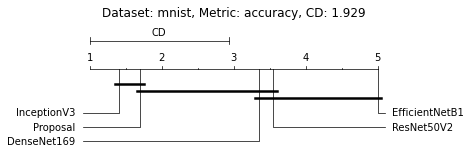

Dataset, objective: mnist f1_score
	 null hypothesis: rejected
	 p-value: 2.6894639286693956e-06
	 ranking: [3.7  1.65 1.5  5.   3.15]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


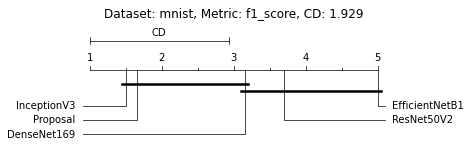

Dataset, objective: kmnist accuracy
	 null hypothesis: rejected
	 p-value: 1.2421918944427845e-06
	 ranking: [4.05 3.15 1.55 4.8  1.45]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


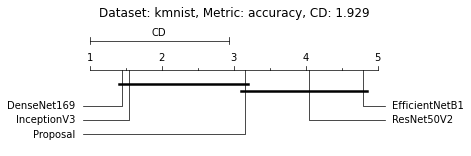

Dataset, objective: kmnist f1_score
	 null hypothesis: rejected
	 p-value: 1.3216380521919027e-06
	 ranking: [4.05 3.15 1.7  4.8  1.3 ]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


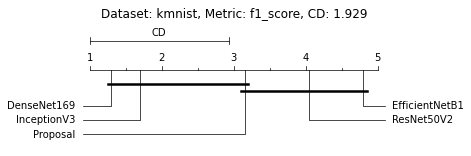

Dataset, objective: eurosat accuracy
	 null hypothesis: rejected
	 p-value: 1.02254989076976e-06
	 ranking: [3.9 1.9 1.4 4.9 2.9]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


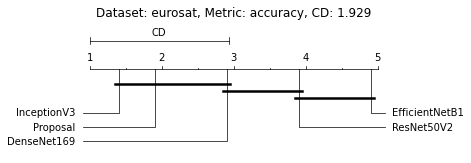

Dataset, objective: eurosat f1_score
	 null hypothesis: rejected
	 p-value: 1.2649166092899542e-06
	 ranking: [3.9 1.9 1.4 4.9 2.9]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


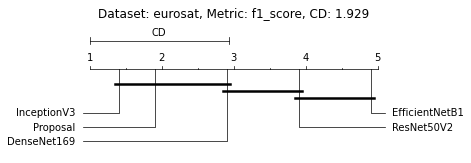

Dataset, objective: cifar10 accuracy
	 null hypothesis: rejected
	 p-value: 1.041984444602479e-06
	 ranking: [4. 1. 3. 5. 2.]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


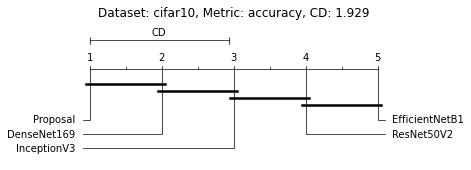

Dataset, objective: cifar10 f1_score
	 null hypothesis: rejected
	 p-value: 2.122730027772513e-06
	 ranking: [4. 1. 3. 5. 2.]
	 names: ['ResNet50V2', 'Proposal', 'InceptionV3', 'EfficientNetB1', 'DenseNet169']
	 cd: 1.9288274929443536


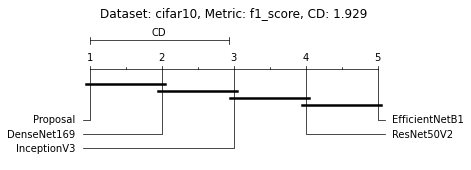

In [ ]:
objectives = ['accuracy', 'f1_score']
alpha = 0.05
 
print('Null hypothesis:', 'The means of the results of two or more algorithms are the same.')

for dataset in DATASETS:
  
  data = df[df.dataset == dataset]
  cnns = data.cnn.unique()
  
  for objective in objectives:
    
    print('Dataset, objective:', dataset, objective)
 
    df1 = pd.DataFrame({cnn: list(data[data.cnn == cnn][objective]) for cnn in cnns})
    values = df1.values
    names = df1.columns    

    friedman = friedmanchisquare(*values)
    ranks = np.array([rankdata(-p) for p in values])
    average_ranks = np.mean(ranks, axis = 0)
    
    cd = compute_CD(average_ranks, n=len(df1), alpha=str(alpha), test='nemenyi')
    
    print('\t', 'null hypothesis:', 'rejected' if friedman.pvalue < alpha else 'accepted')
    print('\t', 'p-value:', friedman.pvalue)
    print('\t', 'ranking:', average_ranks)
    print('\t', 'names:', list(names))
    print('\t', 'cd:', cd)
    
    graph_ranks(average_ranks, names=names, cd=cd)
    # title = f'Friedman-Nemenyi (CD = {round(cd, 3)})'
    title = f'Dataset: {dataset}, Metric: {objective}, CD: {round(cd, 3)}'
    plt.title(title)
    plt.savefig(f'/content/cd_{dataset}_{objective}.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
!tar -cvzf plots.tar.gz /content/*.pdf

tar: Removing leading `/' from member names
/content/cd_cifar10_accuracy.pdf
/content/cd_cifar10_f1_score.pdf
/content/cd_eurosat_accuracy.pdf
/content/cd_eurosat_f1_score.pdf
/content/cd_kmnist_accuracy.pdf
/content/cd_kmnist_f1_score.pdf
/content/cd_mnist_accuracy.pdf
/content/cd_mnist_f1_score.pdf
